In [21]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

In [22]:
files = [
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg001_nrs1_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg002_nrs1_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg003_nrs1_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg001_nrs2_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg002_nrs2_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg003_nrs2_x1dints.fits"  
]

In [23]:
hdul = fits.open(files[2])
hdul.info()

Filename: /home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg003_nrs1_x1dints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     361   ()      
  1  INT_TIMES     1 BinTableHDU     24   1012R x 7C   [J, D, D, D, D, D, D]   
  2  EXTRACT1D     1 BinTableHDU     85   1366R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  3  EXTRACT1D     2 BinTableHDU     85   1366R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  4  EXTRACT1D     3 BinTableHDU     85   1366R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  5  EXTRACT1D     4 BinTableHDU     85   1366R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  6  EXTRACT1D     5 BinTableHDU     85   1366R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  7  EXTRACT1D     6 BinTableHDU     85   1366R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  8  EXTRACT1D     7 BinTableHDU   

In [24]:
num_integration = hdul[0].header["INTEND"] - hdul[0].header["INTSTART"]

num_integration

1011

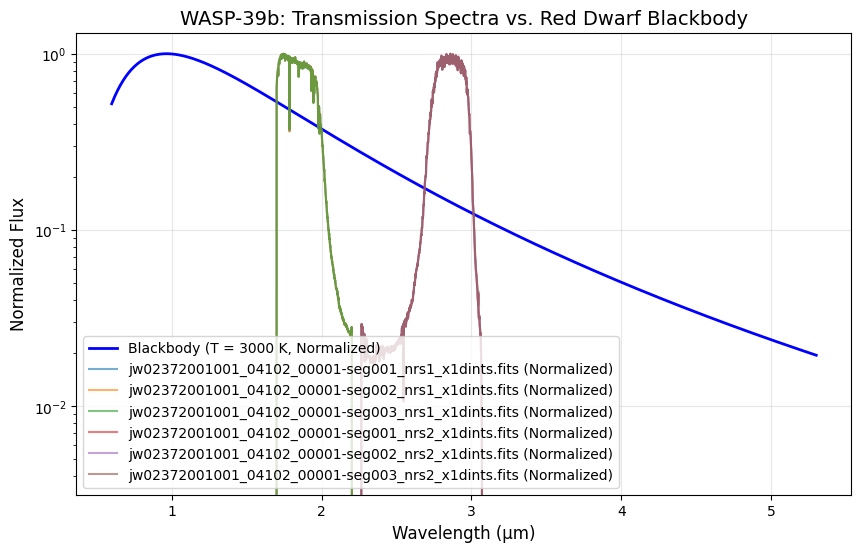

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import median_filter
from scipy.constants import h, c, k
import glob
import os

# Define Planck's law for blackbody radiation
def planck(wavelength, T):
    """Calculate blackbody flux in W/m²/μm."""
    wavelength_m = wavelength * 1e-6  # Convert μm to meters
    factor = 2 * h * c**2 / wavelength_m**5
    exponent = h * c / (wavelength_m * k * T)
    return factor / (np.exp(exponent) - 1) * 1e-6  # Convert to W/m²/μm

# Parameters for blackbody
T = 3000  # Red dwarf temperature (K)
wavelength = np.linspace(0.6, 5.3, 1000)  # Wavelength range in μm (NIRSpec PRISM)
bb_flux = planck(wavelength, T)



# Initialize figure
plt.figure(figsize=(10, 6))

# Plot blackbody curve (normalized to max for comparison)
bb_flux_normalized = bb_flux / np.max(bb_flux)
plt.plot(wavelength, bb_flux_normalized, 'b-', label=f'Blackbody (T = {T} K, Normalized)', linewidth=2)

# Process and plot NIRSpec data
for file in files:
    try:
        with fits.open(file, mode='readonly') as temp:
            # Extract wavelength and flux
            wavlen = temp[2].data["WAVELENGTH"]  # μm
            flux = temp[2].data["FLUX"]          # Jy or MJy/sr
            num_integration = temp[0].header["INTEND"] - temp[0].header["INTSTART"]
            
            # Sum flux over integrations
            summed_flux = np.zeros_like(flux)
            for j in range(num_integration):
                flux_j = temp[j + 2].data["FLUX"]
                summed_flux = np.nansum([summed_flux, flux_j], axis=0)
            
            # Average flux
            avg_flux = summed_flux / num_integration
            
            # IQR outlier removal
            q75, q25 = np.nanpercentile(avg_flux, [75, 25])
            iqr_value = q75 - q25
            mask = (avg_flux >= q25 - 1.5 * iqr_value) & (avg_flux <= q75 + 1.5 * iqr_value)
            avg_flux_cleaned = np.where(mask, avg_flux, np.nan)
            
            # Median filter
            avg_flux_cleaned = median_filter(avg_flux_cleaned, size=3)
            
            # Normalize flux for comparison
            avg_flux_normalized = avg_flux_cleaned / np.nanmax(avg_flux_cleaned)
            
            # Plot
            plt.plot(wavlen, avg_flux_normalized, alpha=0.6, label=f'{os.path.basename(file)} (Normalized)')

    except Exception as e:
        print(f"Error processing {file}: {e}")
        continue

# Finalize plot
plt.xlabel("Wavelength (μm)", fontsize=12)
plt.ylabel("Normalized Flux", fontsize=12)
plt.title("WASP-39b: Transmission Spectra vs. Red Dwarf Blackbody", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.yscale('log')  # Log scale for better visualization
plt.savefig('wasp39b_spectrum.png')
plt.show()

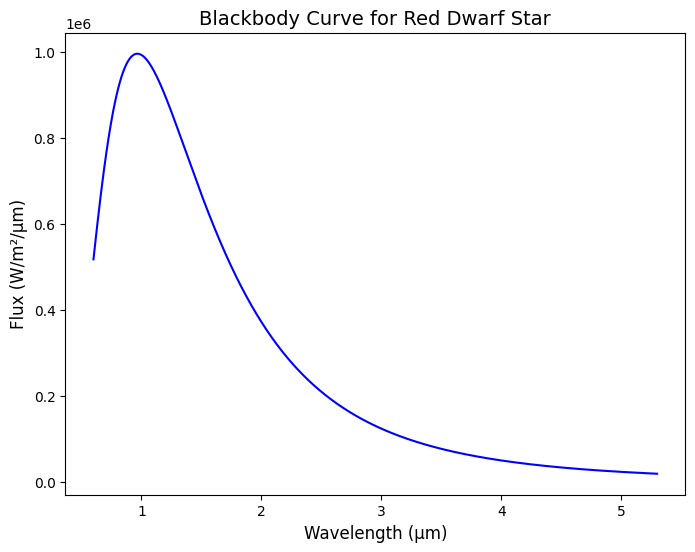

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, c, k


def planck(wavelength, T):
    """Calculate blackbody flux in W/m²/μm."""
    wavelength_m = wavelength * 1e-6  
    factor = 2 * h * c**2 / wavelength_m**5
    exponent = h * c / (wavelength_m * k * T)
    return factor / (np.exp(exponent) - 1) * 1e-6 

T = 3000  
wavelength = np.linspace(0.6, 5.3, 1000)  

flux = planck(wavelength, T)

# Plot the blackbody curve
plt.figure(figsize=(8, 6))
plt.plot(wavelength, flux, 'b-', label=f'Blackbody (T = {T} K)')
plt.xlabel('Wavelength (μm)', fontsize=12)
plt.ylabel('Flux (W/m²/μm)', fontsize=12)
plt.title('Blackbody Curve for Red Dwarf Star', fontsize=14)
plt.show()

In [17]:
import os

os.environ["CRDS_PATH"] = os.path.expanduser("~/crds_cache")
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"


import matplotlib.pyplot as plt

import numpy as np



from jwst import datamodels 


# List of x1dints files
files = [
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg001_nrs1_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg002_nrs1_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg003_nrs1_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg001_nrs2_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg002_nrs2_x1dints.fits",
    "/home/saurav/Desktop/k2-18/jw02372001001_04102_00001-seg003_nrs2_x1dints.fits"
]


def compile_segments(data_products):
    """
    Compiles extracted 1D spectra, corresponding timestamps,
    and wavelengths from a list of X1D data products.

    Parameters
    ----------
    data_products : list of str
        A list of data products (X1DINT files).

    Returns
    -------
    all_spec_1D : numpy.ndarray
        A 2D array where each row corresponds to a spectrum from a single
        integration, and columns represent flux values at each wavelength.
    all_times : numpy.ndarray
        A 1D array containing the mid-integration times (e.g., BJD_TDB) for
        each spectrum in `all_spec_1D`.
    """

    data_products = [data_products] if isinstance(data_products, str) else data_products

    # Return empty arrays if the input list is empty.
    if not data_products:
        return None, None

    for i, product in enumerate(data_products):

        x1d = datamodels.open(product)

        n_spec = len(x1d.spec)
        n_pix = len(x1d.spec[i].spec_table.FLUX)
        seg_spec_1D = np.zeros([n_spec, n_pix])
        wave_um = x1d.spec[0].spec_table.WAVELENGTH

        for j in range(n_spec):
            seg_spec_1D[j, :] = x1d.spec[j].spec_table.FLUX

        if i == 0:
            all_spec_1D = seg_spec_1D
            all_times = x1d.int_times.int_mid_BJD_TDB
        if i > 0:
            all_spec_1D = np.concatenate((all_spec_1D, seg_spec_1D), axis=0)
            all_times = np.concatenate((all_times,
                                        x1d.int_times.int_mid_BJD_TDB),
                                       axis=0)

    # We also trim several columns at the start and end of the spectra.
    # These belong to the reference pixels and are marked 'nan'.
    print("Trimming first/last 5 reference pixels with nan-values ...")
    all_spec_1D = all_spec_1D[:, 5:-5]
    wave_um = wave_um[5:-5]

    return all_spec_1D, all_times, wave_um


nrs1_data = compile_segments(files[0:3])
nrs2_data = compile_segments(files[4:6])


2025-04-20 21:28:43,963 - stpipe - WARNING - /home/saurav/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Trimming first/last 5 reference pixels with nan-values ...
Trimming first/last 5 reference pixels with nan-values ...


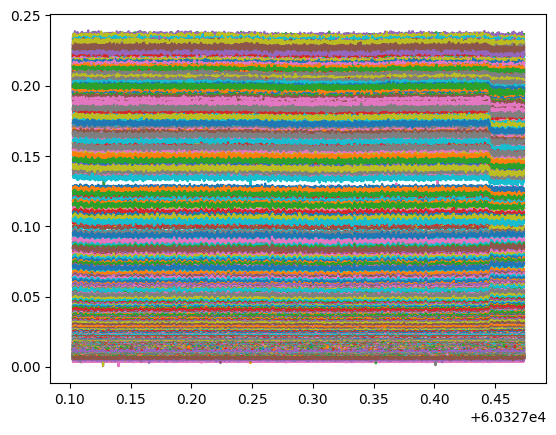

In [ ]:
def display_spectra(data_products,
                    integrations=0,
                    offsets=0):
    """
    Displays the calibrated BOTS spectra from Stage 2.

    Parameters
    ----------
    data_products : str or list of str
        File path or list of file paths to X1D data products.
    integrations : int or list of int, optional
        Indices of integrations to plot (default is 0).
    offset : int or list of int, optional
        Offsets to apply between spectra (default is 0).

    Returns
    -------
    None.
    """

    # -----------------------Check and sort input lists-----------------------
    data_products = [data_products] if isinstance(data_products, str) else data_products
    integrations = [integrations] if isinstance(integrations, int) else integrations
    offsets = [offsets] * len(integrations) if isinstance(offsets, (int)) else offsets

    # Sort NRS1 and NRS2 products.
    products = {
        "NRS1": [f for f in sorted(data_products) if 'nrs1' in f],
        "NRS2": [f for f in sorted(data_products) if 'nrs2' in f]
    }

    # ----------Load extracted spectra and time stamps into one array---------
    for key, product_list in products.items():
        if not product_list:
            continue

        # Load all spectra from list of segments.
        # This makes plotting and analysis easier.
        all_spec1D, all_times, wave_um = compile_segments(product_list)

        # Print summary.
        print(f"\n{key} Summary:")
        print(f"  Total number of time stamps: {len(all_spec1D)}")
        print(f"  Total number of 1D spectra:  {all_spec1D.shape[0]}")
        print(f"  Total number of columns:     {all_spec1D.shape[1]}")
        print(f"  Total length of wavemap:     {len(wave_um)}\n")

        # --------------------------Set up figures--------------------------
        fig, axes = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[1, 2])
        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        ax2d, ax1d = axes

        for idx, i in enumerate(integrations):
            ax1d.plot(wave_um, all_spec1D[i, :] - offsets[idx],
                      label=f'Spectrum {i}')

        ax1d.set_xlabel("Wavelength (microns)")
        ax1d.set_ylabel("Flux (Jy) + Constant offset")
        ax1d.grid(True)
        ax1d.legend()



    fig.show()

    # If no products were found, display a message
    if not any(products.values()):
        print("No NRS1 or NRS2 products found. Exiting.")